In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import shutil
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
!pip install wandb -qU
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
#rename root and test dirs based on dataset
root_dir = '/content/cifar100_train_data'

os.makedirs(root_dir, exist_ok=True)
# change the range to number of classes in dataset
for i in range(100):
    os.makedirs(os.path.join(root_dir, str(i)), exist_ok=True)

In [6]:
trainset = torchvision.datasets.CIFAR100(root=root_dir, train=True, download=True, transform=manual_transforms)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)

100%|██████████| 169001437/169001437 [00:16<00:00, 9990695.79it/s]


Extracting /content/cifar100_train_data/cifar-100-python.tar.gz to /content/cifar100_train_data


In [7]:
class_names = trainset.classes
class_names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [8]:
def save_images_to_folders(dataset, root_dir):
    for idx, (image, label) in enumerate(tqdm(dataset)):
        label_dir = os.path.join(root_dir, str(label))
        img_path = os.path.join(label_dir, f'{idx}.png')
        torchvision.utils.save_image(image, img_path)

In [9]:
save_images_to_folders(trainset, root_dir)

100%|██████████| 50000/50000 [08:32<00:00, 97.51it/s]


In [10]:
shutil.rmtree('/content/cifar100_train_data/cifar-100-python')
os.remove('/content/cifar100_train_data/cifar-100-python.tar.gz')

In [13]:
test_dir = '/content/cifar100_test_data'
os.makedirs(test_dir, exist_ok=True)
for i in range(100):
    os.makedirs(os.path.join(test_dir, str(i)), exist_ok=True)

testset = torchvision.datasets.CIFAR100(root=test_dir, train=False, download=True, transform=manual_transforms)
testloader = DataLoader(trainset, batch_size=1, shuffle=True)

100%|██████████| 169001437/169001437 [00:13<00:00, 12780496.11it/s]


Extracting /content/cifar100_test_data/cifar-100-python.tar.gz to /content/cifar100_test_data


In [14]:
save_images_to_folders(testset, test_dir)

100%|██████████| 10000/10000 [01:41<00:00, 98.80it/s]


In [16]:
shutil.rmtree('/content/cifar100_test_data/cifar-100-python')
os.remove('/content/cifar100_test_data/cifar-100-python.tar.gz')

In [17]:
import os
import pandas as pd

# initialise annotation file names here

train_annotation = 'annotations_cifar100_train.csv'
test_annotation = 'annotations_cifar100_test.csv'

def create_annotations_csv(root_dir, output_file):
    data = []

    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                if os.path.isfile(file_path):
                    data.append([f"{label}/{file_name}", label])

    df = pd.DataFrame(data, columns=['filepath', 'label'])

    df.to_csv(output_file, index=False)

    print(f"{output_file} file created successfully.")

create_annotations_csv(root_dir, train_annotation)
create_annotations_csv(test_dir, test_annotation)

annotations_cifar100_train.csv file created successfully.
annotations_cifar100_test.csv file created successfully.


In [18]:
config = {
    "learning_rate": 0.01,
    "batch_size": 32,
    "epochs": 10,
}

In [19]:
project_name = 'Conformal Prediction Experiments'
run_name = 'CIFAR100 run'
github_url_base = 'https://github.com/Aadharsh1/ML-Deep-Learning/blob/main/Weights_Biases'
file_name = f'{run_name}.ipynb'
notebook_link = f'{github_url_base}/{project_name}/{file_name}'

run = wandb.init(
    project=project_name,
    name=run_name,
    notes=notebook_link,
    config=config,
    )

annotations_path = f'/content/{train_annotation}'
labels_at = wandb.Artifact(f"{train_annotation}", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

annotations_path = f'/content/{test_annotation}'
labels_at = wandb.Artifact(f"{test_annotation}", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

wandb: Currently logged in as: aadharshr-2022 (aadharshr-2022-Singapore Management University). Use `wandb login --relogin` to force relogin


<Artifact annotations_cifar100_test.csv>

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pandas as pd
from PIL import Image

class NewDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #remeber to change 'RGB' to 'L' for greyscale images and vice versa
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [29]:
train_dataset = NewDataset(annotations_file=f'/content/{train_annotation}', img_dir=root_dir, transform=manual_transforms)
test_dataset = NewDataset(annotations_file=f'/content/{test_annotation}', img_dir=test_dir, transform=manual_transforms)


In [30]:
from torch.utils.data import DataLoader, random_split
calibration_size = int(0.02*len(train_dataset))
remaining_size = len(train_dataset) - calibration_size
calibration_set, train_set = random_split(train_dataset, [calibration_size, remaining_size])


In [31]:
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
calib_loader = DataLoader(calibration_set, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

In [32]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = model.to(device)

model.fc = nn.Linear(in_features=2048, out_features=100)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, out_features=10)

In [33]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=config['learning_rate'])

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [34]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))


def validate_function(model, device, validation_dataloader, loss_function, accuracy_function):
  model.eval()
  model = model.to(device)
  validation_loss = 0
  validation_acc = 0

  with torch.inference_mode():
    for X_val, y_val in tqdm(validation_dataloader):
      X_val , y_val = X_val.to(device), y_val.to(device)
      val_logits = model(X_val)
      val_pred = torch.argmax(val_logits, dim=1)
      validation_acc += accuracy_function(y_val, val_pred)
      validation_loss += loss_function(val_logits, y_val)
  return validation_loss/len(validation_dataloader), validation_acc/len(validation_dataloader)

In [35]:
epochs = config['epochs']
for epoch in range(epochs):
  train_loss, trng_acc = train_function(model, device, train_loader, loss_fn, optimizer)
  val_loss, val_acc = validate_function(model, device, test_loader, loss_fn, accuracy_function)
  wandb.log({
        'training_loss': train_loss,
        'training_accuracy': trng_acc,
        'test_loss': val_loss,
        'test_accuracy': val_acc
    })
  print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f}, Testing Loss: {val_loss}, Test Accuracy: {val_acc} ')

  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Training Loss: 2.9854, Training Accuracy: 31.3805, Testing Loss: 1.6394984722137451, Test Accuracy: 54.662539936102235 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Training Loss: 1.3840, Training Accuracy: 61.1945, Testing Loss: 1.1997733116149902, Test Accuracy: 65.75479233226837 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Training Loss: 1.0238, Training Accuracy: 70.3125, Testing Loss: 1.0625710487365723, Test Accuracy: 69.34904153354633 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.8163, Training Accuracy: 75.9954, Testing Loss: 1.1197508573532104, Test Accuracy: 69.07947284345047 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: Training Loss: 0.6621, Training Accuracy: 80.4422, Testing Loss: 1.0280719995498657, Test Accuracy: 71.09624600638978 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: Training Loss: 0.5404, Training Accuracy: 84.0955, Testing Loss: 1.0478620529174805, Test Accuracy: 71.44568690095846 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: Training Loss: 0.4313, Training Accuracy: 87.2817, Testing Loss: 1.0156961679458618, Test Accuracy: 72.40415335463258 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: Training Loss: 0.3446, Training Accuracy: 89.9967, Testing Loss: 1.0405259132385254, Test Accuracy: 72.63378594249201 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: Training Loss: 0.2756, Training Accuracy: 92.1528, Testing Loss: 1.0307869911193848, Test Accuracy: 73.27276357827476 


  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: Training Loss: 0.2149, Training Accuracy: 94.0886, Testing Loss: 1.067526936531067, Test Accuracy: 72.70367412140575 


In [36]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calib_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
n = len(calibration_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.99601096

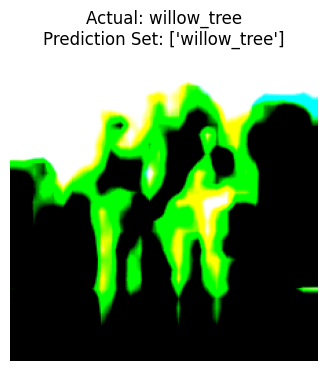

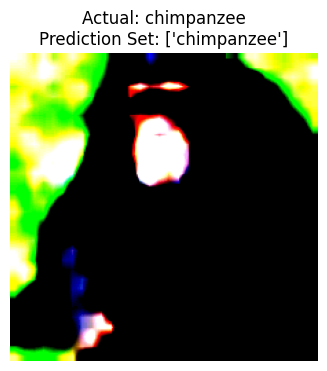

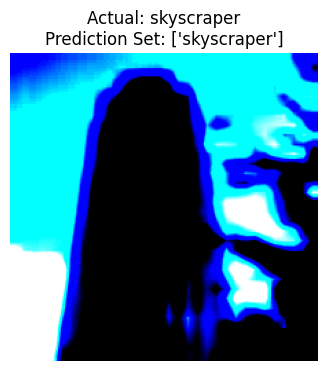

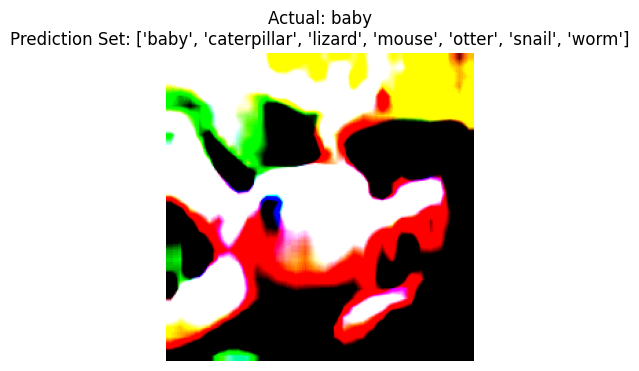

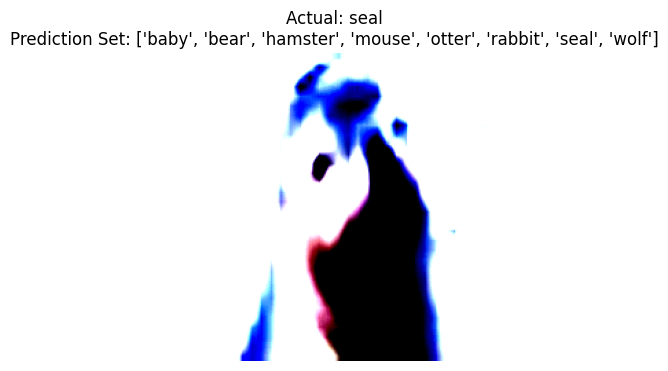

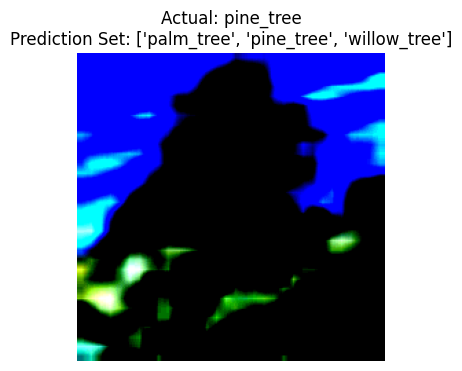

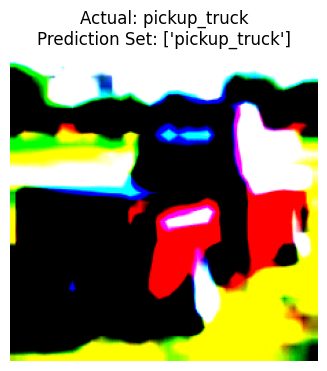

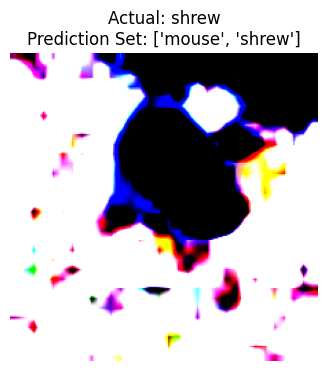

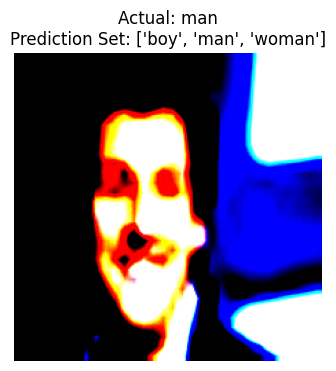

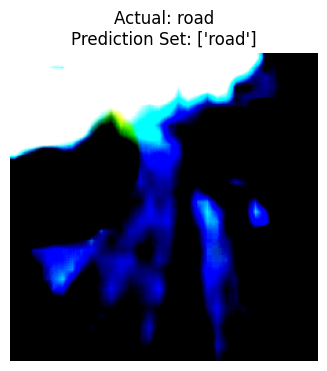

In [38]:
import random
#select 10 indices from the test_data
test_indices = list(range(len(test_dataset)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(test_dataset, selected_indices)
import matplotlib.pyplot as plt

prediction_sets = []
class_names = trainset.classes
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().permute(1,2,0))
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()

In [39]:
project_name = wandb.run.project
run_name = wandb.run.name
# change notebook name according to name of current notebook
notebook_path = '/content/drive/MyDrive/Colab Notebooks/fmnist_annotations.ipynb'

In [40]:
url_path = '/content/drive/MyDrive/github_url.txt'
with open(url_path, 'r') as file:
    github_url = file.read().strip()

In [41]:
import os
import subprocess
import shutil
directory = project_name
file_name = f"{run_name}.ipynb"
file_path = os.path.join('/content/ML-Deep-Learning/Weights_Biases', directory, file_name)

In [ ]:
#shutil.rmtree('/content/ML-Deep-Learning')

In [42]:
repo_path = '/content/ML-Deep-Learning'
if not os.path.exists(repo_path):
    subprocess.run(["git", "clone", github_url, repo_path])

os.chdir(repo_path)

In [43]:
project_directory = os.path.join('Weights_Biases', directory)
if not os.path.exists(project_directory):
    os.makedirs(project_directory)
    print(f"Directory '{project_directory}' created.")
else:
    print(f"Directory '{project_directory}' already exists.")

Directory 'Weights_Biases/Conformal Prediction Experiments' already exists.


In [44]:
shutil.copyfile(notebook_path, file_path)

'/content/ML-Deep-Learning/Weights_Biases/Conformal Prediction Experiments/CIFAR10 run.ipynb'

In [45]:
!git config --global user.email "aadharshrajagopal1@gmail.com"
!git config --global user.name "Aadharsh1"
!git remote set-url origin {github_url}

In [46]:
!cd /content/ML-Deep-Learning/Weights_Biases

In [47]:
!git add .

In [48]:
!git commit -m "Add notebook"

[main c709609] Add notebook
 1 file changed, 1 insertion(+)
 create mode 100644 Weights_Biases/Conformal Prediction Experiments/CIFAR10 run.ipynb


In [49]:
!git push origin main

Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 12 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 423.21 KiB | 11.44 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Aadharsh1/ML-Deep-Learning.git
   4ea67b0..c709609  main -> main


In [50]:
wandb.finish()

test_accuracy,▁▃▅▅▆▆▇▇██
test_loss,█▆▄▄▃▃▂▂▁▁
training_accuracy,▁▃▅▅▆▇▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
test_accuracy,71.80533
test_loss,0.82201
training_accuracy,74.75196
training_loss,0.7203
